In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/akshay/proj/ephys_analysis')

from myinit import *
from load_neural_data import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.titleweight'] = 'bold'

sns.set(font='Helvetica', style='ticks')
matplotlib.rcParams['text.color'] = [0,0,0]
sns.set_palette(sns.husl_palette(h=0.6))
colors = sns.color_palette()

# Classification Functions

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def fit_lr_rus(clf, X_train, y_train, X_test, n_perms=10):
    rus = RandomUnderSampler()
    acc, perm = np.zeros((n_perms,)), np.zeros((n_perms,))
    
    for i in range(n_perms):
        X_rus, y_rus = rus.fit_resample(X_train, y_train)
        clf.fit(X_rus, y_rus)
        acc[i] = np.nanmean(clf.predict(X_test))
        
        clf.fit(X_rus, np.random.permutation(y_rus))
        perm[i] = np.nanmean(clf.predict(X_test))
    return acc, perm

def classify_category_exemplar(neural_resp, stimulus_metadata, n_perms=10):
    ## Are images with conflicting shape and texture represented more similarly to images with matching shape or those with matching texture?
    #   - For each combination of shape + texture, train a binary classifier (SVM) to classify as either shape or texture. 
    #   - Fit on all images that have the same shape + diff texture (class 1) or same texture + diff shape (class 2). 
    #      Test on conflicting images to see if it's classified into class 1 or class 2.
    fnu_categ = stimulus_metadata['category']
    fnu_object = stimulus_metadata['object']
    fnu_objview = stimulus_metadata['object_viewpoint']
    
    uobjs, uobjidx = np.unique(fnu_object, return_index=True)
    uobjcategs = fnu_categ[uobjidx]
    
    uviews, uviewidx = np.unique(fnu_objview, return_index=True)
    uviewobj = fnu_object[uviewidx]
    uviewcateg = fnu_categ[uviewidx]

    ###
    accuracy = {'category': np.zeros((len(uobjs), n_perms)), # category
             'exemplar': np.zeros((len(uviews), n_perms)), # exemplar
           }
    perm = {'category': np.zeros((len(uobjs), n_perms)), # category
            'exemplar': np.zeros((len(uviews), n_perms)), # exemplar
           }


    for ui, uobj in enumerate(uobjs):
        lr = LinearSVC(dual='auto', class_weight='balanced')
        
        ######
        # Category vs Other: Leave this [exemplar x texture] combination out.
        #     - Train a binary classifier for each category to predict category vs other.
        train_idx = (fnu_object!=uobj)
        train_labels = (fnu_categ[train_idx]==uobjcategs[ui])
        
        # Test on images of this examplar x texture.
        test_idx = (fnu_object==uobj)

        # Split data into train and test and fit.
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
        accuracy['category'][ui,:], perm['category'][ui,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)
                

    ########
    for uvi, uview in enumerate(uviews):
        lr = LinearSVC(dual='auto', class_weight='balanced')
        # Instance vs Other: Within-category classification. 
        #     Train to discriminate images from different exemplars of the same category.
        #     Leave-one-viewpoint out.
        train_idx = (fnu_categ == uviewcateg[uvi]) * (fnu_objview != uview)
        test_idx = (fnu_objview == uview)
        train_labels = (fnu_object[train_idx] == uviewobj[uvi])
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
    
        accuracy['exemplar'][uvi,:], perm['exemplar'][uvi,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)
       
    return accuracy, perm

def classify_category_exemplar_original(neural_resp, stimulus_metadata, n_perms=10):
    ## Are images with conflicting shape and texture represented more similarly to images with matching shape or those with matching texture?
    #   - For each combination of shape + texture, train a binary classifier (SVM) to classify as either shape or texture. 
    #   - Fit on all images that have the same shape + diff texture (class 1) or same texture + diff shape (class 2). 
    #      Test on conflicting images to see if it's classified into class 1 or class 2.
    fnu_categ = stimulus_metadata['category']
    fnu_object = stimulus_metadata['object']
    fnu_objview = stimulus_metadata['object_viewpoint']
    
    uobjs, uobjidx = np.unique(fnu_object, return_index=True)
    uobjcategs = fnu_categ[uobjidx]
    
    uviews, uviewidx = np.unique(fnu_objview, return_index=True)
    uviewobj = fnu_object[uviewidx]
    uviewcateg = fnu_categ[uviewidx]

    ###
    accuracy = {'category': np.zeros((len(uviews), n_perms)), # category
             'exemplar': np.zeros((len(uviews), n_perms)), # exemplar
           }
    perm = {'category': np.zeros((len(uviews), n_perms)), # category
            'exemplar': np.zeros((len(uviews), n_perms)), # exemplar
           }

    ########
    for uvi, uview in enumerate(uviews):
        lr = LinearSVC(dual='auto', class_weight='balanced')
        
        ######
        # Category vs Other: Leave this viewpoint out.
        train_idx = (fnu_objview != uview)
        train_labels = (fnu_categ[train_idx]==uviewcateg[uvi])
        
        # Test on this viewpoint.
        test_idx = (fnu_objview == uview)

        # Split data into train and test and fit.
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
        accuracy['category'][uvi,:], perm['category'][uvi,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)

        
        lr = LinearSVC(dual='auto', class_weight='balanced')
        # Instance vs Other: Within-category classification. 
        #     Train to discriminate images from different exemplars of the same category.
        #     Leave-one-viewpoint out.
        train_idx = (fnu_categ == uviewcateg[uvi]) * (fnu_objview != uview)
        test_idx = (fnu_objview == uview)
        train_labels = (fnu_object[train_idx] == uviewobj[uvi])
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
    
        accuracy['exemplar'][uvi,:], perm['exemplar'][uvi,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)
       
    return accuracy, perm

def classify_category_exemplar_stylized(neural_resp, stimulus_metadata, n_perms=10):
    ## Are images with conflicting shape and texture represented more similarly to images with matching shape or those with matching texture?
    #   - For each combination of shape + texture, train a binary classifier (SVM) to classify as either shape or texture. 
    #   - Fit on all images that have the same shape + diff texture (class 1) or same texture + diff shape (class 2). 
    #      Test on conflicting images to see if it's classified into class 1 or class 2.
    fnu_categ = stimulus_metadata['category']
    fnu_object = stimulus_metadata['object']
    fnu_objview = stimulus_metadata['object_viewpoint']
    fnu_texture = stimulus_metadata['texture']
    stim_names = stimulus_metadata['stimulus_name']
    
    uobjs, uobjidx = np.unique(fnu_object, return_index=True)
    uobjcategs = fnu_categ[uobjidx]
    
    uviews, uviewidx = np.unique(fnu_objview, return_index=True)
    uviewobj = fnu_object[uviewidx]
    uviewcateg = fnu_categ[uviewidx]
    uviewtex = fnu_texture[uviewidx]

    ###
    accuracy = {'category': np.zeros((len(stim_names), n_perms)), # category
             'exemplar': np.zeros((len(stim_names), n_perms)), # exemplar
           }
    perm = {'category': np.zeros((len(stim_names), n_perms)), # category
            'exemplar': np.zeros((len(stim_names), n_perms)), # exemplar
           }

    ########
    for si, stim in enumerate(stim_names):
        lr = LinearSVC(dual='auto', class_weight='balanced')
        ######
        # Category vs Other: Leave this [exemplar x texture] combination out.
        #     - Train a binary classifier for each category to predict category vs other.
        train_idx = (fnu_object != fnu_object[si])*(fnu_texture != fnu_texture[si])
        train_labels = (fnu_categ[train_idx]==fnu_categ[si])
        test_idx = (stim_names==stim)
        
        # Split data into train and test and fit.
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
        accuracy['category'][si,:], perm['category'][si,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)
        
    # for uvi, uview in enumerate(uviews):
        
        lr = LinearSVC(dual='auto', class_weight='balanced')
        # Instance vs Other: Within-category classification. 
        #     Train to discriminate images from different exemplars of the same category.
        #     Leave-one-viewpoint out.
        train_idx = (fnu_categ == fnu_categ[si]) * (fnu_objview != fnu_objview[si]) * (fnu_texture != fnu_texture[si])
        test_idx = (fnu_objview == fnu_objview[si]) * (fnu_texture == fnu_texture[si])
        
        train_labels = (fnu_object[train_idx] == fnu_object[si])
        X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
    
        accuracy['exemplar'][si,:], perm['exemplar'][si,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)

    return accuracy, perm

def classify_texture_color(neural_resp, stimulus_metadata, n_perms=10):
    ## Are images with conflicting shape and texture represented more similarly to images with matching shape or those with matching texture?
    #   - For each combination of shape + texture, train a binary classifier (SVM) to classify as either shape or texture. 
    #   - Fit on all images that have the same shape + diff texture (class 1) or same texture + diff shape (class 2). 
    #      Test on conflicting images to see if it's classified into class 1 or class 2.
    fnu_categ = stimulus_metadata['category']
    fnu_object = stimulus_metadata['object']
    fnu_texture = stimulus_metadata['texture']
    fnu_color = stimulus_metadata['color']
    
    uobjs, uobjidx = np.unique(fnu_object, return_index=True)
    uobjcategs = fnu_categ[uobjidx]

    utexs = np.unique(fnu_texture)

    ucolors = np.unique(fnu_color)
    ucolors = ucolors[ucolors!='orig']
    
    # lr = LogisticRegression(class_weight='balanced')
    
    accuracy = {
                 'texture': np.zeros((len(uobjs), len(utexs), n_perms)),  # texture
                 'color': np.zeros((len(uobjs), len(ucolors), n_perms)),# color
               }
    perm = {
             'texture': np.zeros((len(uobjs), len(utexs), n_perms)),  # texture
             'color': np.zeros((len(uobjs), len(ucolors), n_perms)),# color
           }
    
    lr = LinearSVC(dual='auto', class_weight='balanced')
    
    
    for ui, uobj in enumerate(uobjs):    
        for uti, utex in enumerate(utexs):
            ######
            # Texture vs Other: Train on images from the same category (exclude same exemplar images) vs. from different categories. 
            train_idx = np.logical_not((fnu_object==uobj)*(fnu_texture==utex))
            # train_idx = (fnu_categ == uobjcategs[ui])*(fnu_object!=uobj)
            train_labels = (fnu_texture[train_idx]==utex)
            
            # Test on images of this examplar x texture.
            test_idx = (fnu_object==uobj)*(fnu_texture==utex)

            if np.sum(test_idx) <= 1:
                accuracy['texture'][ui,uti,:], perm['texture'][ui,uti,:] = np.nan, np.nan
                continue

            # Split data into train and test and fit.
            X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
            accuracy['texture'][ui,uti,:], perm['texture'][ui,uti,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)

        for uci, ucol in enumerate(ucolors):
            ######
            # Color vs Other: Train on images from the same category (exclude same exemplar images) vs. from different categories. 
            train_idx = np.logical_not((fnu_object==uobj)*(fnu_color==ucol))
            # train_idx = (fnu_categ == uobjcategs[ui])*(fnu_object!=uobj)
            train_labels = (fnu_color[train_idx]==ucol)
            
            # Test on images of this examplar x texture.
            test_idx = (fnu_object==uobj)*(fnu_color==ucol)

            if np.sum(test_idx) <= 1:
                accuracy['color'][ui,uci,:], perm['color'][ui,uci,:] = np.nan, np.nan
                continue

            # Split data into train and test and fit.
            X_train, X_test = neural_resp[train_idx,:], neural_resp[test_idx,:]
            accuracy['color'][ui,uci,:], perm['color'][ui,uci,:] = fit_lr_rus(lr, X_train, train_labels, X_test, n_perms=n_perms)
       
    return accuracy, perm

# Category and exemplar decoding: stylized vs. non-stylized

## Category and exemplar decoding on objaverse original

In [4]:
data_orig = load_from_hdf5('data/objaverse_ephys-data_2024.h5')

In [ ]:
features = {}
start = time.time()
with h5py.File('features/features_objaverse_850pcs.h5', 'r') as f:
    for key in f.keys():
        features[key] = f[key][()]

In [8]:
# Mean response (over best time period)
shape_acc_orig, shape_perm_orig = {}, {}
for si, sess_name in tqdm(enumerate(data_orig), total=len(data_orig)):
    resp_peak = data_orig[sess_name]['repavg']['response_peak']
    stimulus_metadata = data_orig[sess_name]['repavg']['stimulus_metadata']
    brain_areas = data_orig[sess_name]['neuron_metadata']['brain_area']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        key = sess_name+'_'+area
        shape_acc_orig[key], shape_perm_orig[key] = classify_category_exemplar_original(resp_peak[:,brain_areas==area], 
                                                                                        stimulus_metadata, 
                                                                                        n_perms=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:06<00:00, 35.15s/it]


## Category and exemplar decoding on objaverse stylized

In [ ]:
data_sty = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')

In [ ]:
# Mean response (over best time period)
shape_acc_sty, shape_perm_sty = {}, {}
for si, sess_name in tqdm(enumerate(data_sty), total=len(data_sty)):
    resp_peak = data_sty[sess_name]['repavg']['response_peak']
    stimulus_metadata = data_sty[sess_name]['repavg']['stimulus_metadata']
    stimulus_metadata['stimulus_name'] = data_sty[sess_name]['repavg']['stimulus_name']
    brain_areas = data_sty[sess_name]['neuron_metadata']['brain_area']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        shape_acc_sty[sess_name+'_'+area], shape_perm_sty[sess_name+'_'+area] = classify_category_exemplar_stylized(resp_peak[:,brain_areas==area], 
                                                                                                                stimulus_metadata, 
                                                                                                                n_perms=2)

## Monkeys: Plot stylized vs non-stylized shape decoding results

In [ ]:
sess_names_nonstylized = {
              'V1': ['paul_240330-240404_V1'],
              'V2': ['paul_240330-240404_V2'],
              'pIT': ['paul_240330-240404_pIT'],
              'cIT': ['baby1_240330-240402_cIT',
                      'louie_20240331-20240403_l_cIT', 
                      'paul_20240330-20240404_l_cIT',  
                      'paul_240330-240404_cIT',
                      'sweetie_20240331-20240403_l_cIT', ],
              'aIT': ['baby1_20240330-20240403_r_aIT',  
                      'baby1_240330-240402_aIT', 
                      'red_20240330-20240403_l_aIT', 
                      'sweetie_20240331-20240403_r_aIT',],
             }
sess_names_stylized = {
              'V1': ['paul_240405-240416_V1'],
              'V2': ['paul_240405-240416_V2'],
              'pIT': ['paul_240405-240416_pIT'],
              'cIT': [ 'anthony_20240117-20240419_r_cIT',
                      'paul_240405-240416_cIT','baby1_240117-240419_cIT',
                     'louie_20240117-20240419_l_cIT', 'paul_20240405-20240416_l_cIT', 'sweetie_20240117-20240419_l_cIT',
                     ],
              'aIT': ['anthony_20240117-20240419_r_aIT',  
                      'baby1_20240117-20240419_r_aIT', 
                      'baby1_240117-240419_aIT', 
                      'red_20240117-20240419_l_aIT','sweetie_20240117-20240419_r_aIT'],
             }

####
colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[0], colors[1], colors[2], colors[3],]
titles = ['category', 'exemplar',]#, 'texture vs. category',]
behavkeys = ['betweencateg', 'withincateg']

fig,axes = plt.subplots(1,len(titles),figsize=(7.5, 4))
for i, title in enumerate(titles):
    ax = axes.ravel()[i]
    
    for ai, arrayloc in enumerate(sess_names_stylized.keys()):
        # First plot non-stylized classification accuracy
        xshift = np.linspace(-.2, .2, len(sess_names_nonstylized[arrayloc])) if len(sess_names_nonstylized[arrayloc])>1 else np.array([0])
        barwidth = xshift[1] - xshift[0] if len(sess_names_nonstylized[arrayloc])>1 else 0.5
        colshifts = np.linspace(.7, 1.3, len(sess_names_nonstylized[arrayloc])) if len(sess_names_nonstylized[arrayloc])>1 else [1]
        accs = []
        for si, sess_name in enumerate(sess_names_nonstylized[arrayloc]):
            sb = shape_acc_orig[sess_name][title] 
            ax.errorbar(ai+xshift[si]-.2, np.nanmean(sb), marker='.', 
                       yerr=SE(np.ravel(sb)),
                       color='k', alpha=0.4, 
                       label=None,
                      )
            accs.append(np.nanmean(sb))
        ax.bar(ai-.2, np.nanmean(accs), width=0.4, yerr = SE(np.ravel(accs)), 
               color=0.8*np.array(colors[i]), label='Original' if ai==0 else None)
        
        p = [shape_perm_orig[sess_name][title] for sess_name in sess_names_nonstylized[arrayloc]]
        p_mean = np.array([np.nanmean(np.reshape(pi, (pi.shape[0], -1))) for pi in p])
        p_se = np.array([SE(np.nanmean(np.reshape(pi, (pi.shape[0],-1)), axis=-1)) for pi in p])
        X = ai + (xshift*1.5) if len(xshift)>1 else np.array([ai-0.25, ai+0.25])
        ax.fill_between(X-.2, p_mean-p_se, p_mean+p_se, color='gray', alpha=.8)
        
        # Then plot stylized
        xshift = np.linspace(-.2, .22, len(sess_names_stylized[arrayloc])) if len(sess_names_stylized[arrayloc])>1 else np.array([0])
        barwidth = xshift[1] - xshift[0] if len(sess_names_stylized[arrayloc])>1 else 0.5
        colshifts = np.linspace(.7, 1.3, len(sess_names_stylized[arrayloc])) if len(sess_names_stylized[arrayloc])>1 else [1]
        accs = []
        for si, sess_name in enumerate(sess_names_stylized[arrayloc]):
            sb = shape_acc_sty[sess_name][title] 
            ax.errorbar(ai+xshift[si]+.2, np.nanmean(sb), marker='.', #width=barwidth,
                   yerr=SE(np.ravel(sb)),
                   color='k', alpha=0.4, #np.minimum(colshifts[si]*np.array(colors[1+ai]), 1.0), 
                   label=None,
                  )
            accs.append(np.nanmean(sb))
        ax.bar(ai+.2, np.nanmean(accs), width=0.4, yerr = SE(np.ravel(accs)), 
               color=colors[i], label='Stylized' if ai==0 else None)
        p = [shape_perm_sty[sess_name][title] for sess_name in sess_names_stylized[arrayloc]]
        p_mean = np.array([np.nanmean(np.reshape(pi, (pi.shape[0], -1))) for pi in p])
        p_se = np.array([SE(np.nanmean(np.reshape(pi, (pi.shape[0],-1)), axis=-1)) for pi in p])
        X = ai + (xshift*1.5) if len(xshift)>1 else np.array([ai-0.25, ai+0.25])
        ax.fill_between(X+.2, p_mean-p_se, p_mean+p_se, color='gray', alpha=.8)

    ax.set_ylim(0.35, 0.8)
    ax.set_xticks(np.arange(len(sess_names)))
    ax.set_xticklabels(sess_names.keys(), rotation=0)
    ax.set_title(f'{title}')
    ax.set_ylabel('SVM Classification Accuracy')
    ax.legend(frameon=False)

sns.despine(trim=True)
fig.savefig(f'figures/objaverse_2024/orig-vs-stylized_svm-shape-decoding_brain.pdf', bbox_inches='tight', transparent=True)

## DNNs: Plot stylized vs. non-stylized shape decoding results

In [ ]:
dnn_shape_acc_orig = load_from_hdf5('results/dnn-64pcs_objaverse_svm-results.h5')
dnn_shape_acc_sty = load_from_hdf5('results/dnn-64pcs_objaverse-stylized_svm-results.h5')

In [ ]:
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]
####
colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[0], colors[3], ]
titles = ['category', 'exemplar',]#, 'texture vs. category',]
behavkeys = ['betweencateg', 'withincateg']

fig,axes = plt.subplots(1,len(titles),figsize=(9, 4))
for i, title in enumerate(titles):
    ax = axes.ravel()[i]

    # Plot non-stylized
    acc = np.array([dnn_shape_acc_orig['accuracy'][modellayer][title] for modellayer in modellayers]) 
    perm = np.array([dnn_shape_acc_orig['perm'][modellayer][title] for modellayer in modellayers])
    ax.bar(np.arange(len(modellayers))-.2, np.nanmean(acc, axis=(1,2)), width=0.4, yerr=SE(np.reshape(acc, [acc.shape[0], -1]), axis=1),
           color = 0.8*np.array(colors[i]), label = 'Original')
    p_mean = np.nanmean(perm, axis=(1,2))
    p_se = SE(np.reshape(perm, [perm.shape[0],-1]), axis=1)
    
    for mi, modellayer in enumerate(modellayers):
        ax.fill_between(np.array([mi-0.25, mi+0.25])-.2, p_mean[mi]-p_se[mi], p_mean[mi]+p_se[mi], color='gray', alpha=.8)

    # plot stylized
    acc = np.array([dnn_shape_acc_sty['accuracy'][modellayer][title] for modellayer in modellayers]) 
    perm = np.array([dnn_shape_acc_sty['perm'][modellayer][title] for modellayer in modellayers])
    ax.bar(np.arange(len(modellayers))+.2, np.nanmean(acc, axis=(1,2)), width=0.4, yerr=SE(np.reshape(acc, [acc.shape[0], -1]), axis=1),
           color = np.array(colors[i]), label = 'Stylized')
    p_mean = np.nanmean(perm, axis=(1,2))
    p_se = SE(np.reshape(perm, [perm.shape[0],-1]), axis=1)
    
    for mi, modellayer in enumerate(modellayers):
        ax.fill_between(np.array([mi-0.25, mi+0.25])+.2, p_mean[mi]-p_se[mi], p_mean[mi]+p_se[mi], color='gray', alpha=.8)

    ax.set_ylim(0.2, 1)
    ax.set_xticks(np.arange(len(modellayers)), modellayers, rotation=90)
    ax.set_title(f'{title}')
    ax.set_ylabel('SVM Classification Accuracy')
    ax.legend(frameon=False)

sns.despine(trim=True)
fig.savefig(f'figures/paper_figures/orig-vs-stylized_svm-shape-decoding_DNN.pdf', bbox_inches='tight', transparent=True)

In [ ]:
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]

sty_acc = np.array([dnn_acc_sty['accuracy'][model]['category'] for model in modellayers])
orig_acc = np.array([dnn_acc['accuracy'][model]['category'] for model in modellayers])

fig, ax = plt.subplots()
colors = sns.husl_palette(h=0.6, n_colors=6)
ax.errorbar(np.nanmean(orig_acc, axis=(1,2)), np.nanmean(sty_acc, axis=(1,2)),
            xerr=SE(np.reshape(orig_acc, [orig_acc.shape[0], -1]), axis=1),
            yerr=np.nanmean(np.nanstd(sty_acc, axis=-1), axis=-1),
            marker='o', ls ='None', label = 'category', color=colors[0]
           )

sty_acc = np.array([dnn_acc_sty['accuracy'][model]['exemplar'] for model in modellayers])
orig_acc = np.array([dnn_acc['accuracy'][model]['exemplar'] for model in modellayers])

ax.errorbar(np.nanmean(orig_acc, axis=(1,2)), np.nanmean(sty_acc, axis=(1,2)),
            xerr=SE(np.reshape(orig_acc, [orig_acc.shape[0], -1]), axis=1),
            yerr=np.nanmean(np.nanstd(sty_acc, axis=-1), axis=-1),
            marker='o', ls ='None', label = 'exemplar', color=colors[3]
           )
ax.legend(frameon=False, labelcolor=[colors[0], colors[3]], loc='upper left', prop = {'style': 'oblique', 'weight': 'bold'})
ax.axhline(0.5, ls='--', color='gray')
ax.axvline(0.5, ls='--', color='gray')
ax.plot([.4,1], [.4,1], '--', color='gray')
sns.despine(trim=True)


# Decoding texture and color

In [28]:
data_sty = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')

In [29]:
stim_meta = data_sty['baby1_240117-240419']['repavg']['stimulus_metadata']


In [41]:
np.unique(stim_meta['category'])

(20,)

In [ ]:
with open('brain_feature_classification.pkl', 'rb') as f:
    res = pickle.load(f)
accuracies, perms = res['accuracy'], res['perm']

In [ ]:
# sess_names = list(accuracies.keys())

sess_names = {'V1': ['paul_240405-240416_V1'],
              'V2': ['paul_240405-240416_V2'],
              'pIT': ['paul_240405-240416_pIT'],
              'cIT': ['baby1_240117-240419_cIT', 'louie_20240117-20240419_l_cIT',  'sweetie_20240117-20240419_l_cIT', 
                      'paul_20240405-20240416_l_cIT', ],
              'aIT': ['baby1_240117-240419_aIT',  'baby1_20240117-20240419_r_aIT', 
                      'anthony_20240117-20240419_r_aIT', 'red_20240117-20240419_l_aIT',]# 'jordan_20240117-20240121_l_aIT']
             }

####
colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[1], colors[2]]
titles = ['texture', 'color']#, 'texture vs. category',]
behavkeys = ['betweentexture', 'betweencolor',]

fig,axes = plt.subplots(figsize=(7,4))

barshift = np.linspace(-.2, .2, len(titles))
area_colors = sns.color_palette('rocket', n_colors = 5)

for i, title in enumerate(titles):
    ax = axes
    
    for ai, arrayloc in enumerate(sess_names.keys()):
        xshift = np.linspace(-.15, .15, len(sess_names[arrayloc])) if len(sess_names[arrayloc])>1 else np.array([0])
        barwidth = xshift[1] - xshift[0] if len(sess_names[arrayloc])>1 else 0.5
        
        colshifts = np.linspace(.7, 1.3, len(sess_names[arrayloc])) if len(sess_names[arrayloc])>1 else [1]
        accs = []
        for si, sess_name in enumerate(sess_names[arrayloc]):
            sb = accuracies[sess_name][title] 
            ax.errorbar(ai+xshift[si]+barshift[i], np.nanmean(sb), marker='.', #width=barwidth,
                   yerr=SE(np.ravel(sb)), markersize=10,
                   color='gray', alpha=0.7, markeredgecolor='white',
                   label=None,
                  )
            # ax.text(ai+xshift[si], .35+0.02, sess_name.split('_')[0], rotation = 90, fontsize=8, ha='center')#, va='center')
            accs.append(np.nanmean(sb))
        ax.bar(ai + barshift[i], np.nanmean(accs), width=0.4, yerr = SE(np.ravel(accs)), 
               color=colors[i], label=title if ai==0 else None)
        
        p = [perms[sess_name][title] for sess_name in sess_names[arrayloc]]
        p_mean = np.array([np.nanmean(np.reshape(pi, (pi.shape[0], -1))) for pi in p])
        p_se = np.array([SE(np.nanmean(np.reshape(pi, (pi.shape[0],-1)), axis=-1)) for pi in p])
        
        X = ai + (xshift*1.5) if len(xshift)>1 else [ai-0.25, ai+0.25]        
        ax.fill_between(X+barshift[i], p_mean-p_se, p_mean+p_se, color='gray', alpha=.8)

ax.legend(frameon=False, labelcolor=colors)
ax.set_ylim(0.35, 0.7)
ax.set_xticks(np.arange(len(sess_names)))
ax.set_xticklabels(sess_names.keys(), rotation=0)
ax.set_title(f'Texture and color decoding')
ax.set_ylabel('SVM Classification Accuracy')

sns.despine(trim=True)
fig.savefig(f'figures/paper_figures/texture-color_decoding_brain.pdf',bbox_inches='tight', transparent=True)


In [4]:
res = load_from_hdf5('results/dnn-64pcs_objaverse-stylized_texture-color_svm-results.h5')
dnn_accuracies, dnn_perms = res['accuracy'], res['perm']

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


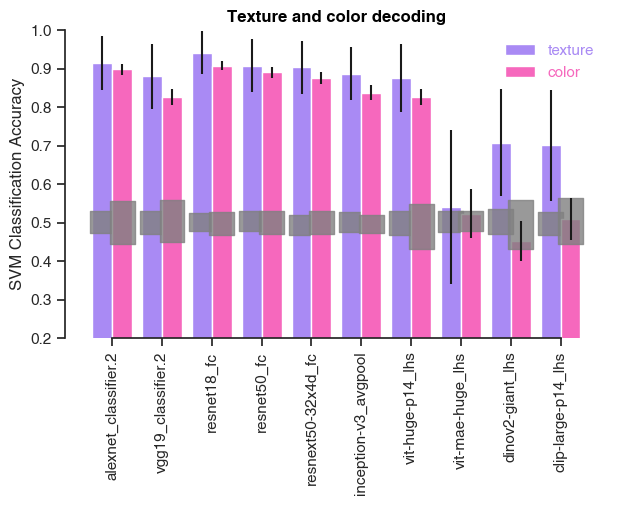

In [23]:
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]
####
colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[1], colors[2], ]
titles = ['texture', 'color',]#, 'texture vs. category',]


fig,axes = plt.subplots(figsize=(7,4))

barshift = np.linspace(-.2, .2, len(titles))
area_colors = sns.color_palette('rocket', n_colors = 5)

for i, title in enumerate(titles):
    ax = axes
    
    accs = np.array([dnn_accuracies[modelname][title] for modelname in modellayers])
    yerr = SE(np.reshape(accs, [accs.shape[0], -1]),axis=1)
    yerr = np.nanmean(np.nanstd(accs, axis=-1), axis=(1,2))
    ax.bar(np.arange(len(dnn_accuracies)) + barshift[i], np.nanmean(accs, axis=(1,2,3)), yerr = yerr, 
           width=0.4, color=colors[i], label=title)# if ai==0 else None)
    
    p = [dnn_perms[modelname][title] for modelname in modellayers]
    p_mean = np.array([np.nanmean(np.reshape(pi, (pi.shape[0], -1))) for pi in p])
    p_se = np.array([np.nanstd(np.nanmean(np.reshape(pi, (pi.shape[0],-1)), axis=-1)) for pi in p])
    # p_se = np.nanmean(SE(np.array(p), axis=-1), axis=(1,2))
    for mi, modelname in enumerate(modellayers):
        X = np.array([mi-0.25, mi+0.25])
        ax.fill_between(X+barshift[i], (p_mean-p_se)[mi], (p_mean+p_se)[mi], color='gray', alpha=.8)

ax.legend(frameon=False, labelcolor=colors)
ax.set_ylim(0.2, 1)
ax.set_xticks(np.arange(len(modellayers)), modellayers, rotation=90)
ax.set_title(f'Texture and color decoding')
ax.set_ylabel('SVM Classification Accuracy')

sns.despine(trim=True)
fig.savefig(f'figures/paper_figures/DNN_texture-color_decoding.pdf', bbox_inches='tight', transparent=True)

In [ ]:
# Mean response (over best time period)
# tc_acc, tc_perm = {}, {}
for si, sess_name in tqdm(enumerate(data_sty), total=len(data_sty)):
    if 'jordan' in sess_name: continue
    resp_peak = data_sty[sess_name]['repavg']['response_peak']
    stimulus_metadata = data_sty[sess_name]['repavg']['stimulus_metadata']
    brain_areas = data_sty[sess_name]['neuron_metadata']['brain_area']
    if type(brain_areas[0])==bytes:
        brain_areas = np.array([x.decode('utf-8') for x in brain_areas])
    uareas = np.unique(brain_areas)
    for ai, area in enumerate(uareas):
        key = f'{sess_name}_{area}'
        if key in tc_acc: continue
        if resp_peak[:,brain_areas==area].shape[1] <= 2: 
            print('Not enough good units in {key}. Skipping')
            continue
        tc_acc[key], tc_perm[key] = classify_texture_color(resp_peak[:,brain_areas==area], 
                                                           stimulus_metadata, 
                                                           n_perms=2)

In [ ]:
# sess_names = list(accuracies.keys())

sess_names = {'V1': ['paul_240405-240416_V1'],
              'V2': ['paul_240405-240416_V2'],
              'pIT': ['paul_240405-240416_pIT'],
              'cIT': ['baby1_240117-240419_cIT', 'louie_20240117-20240419_l_cIT',  'sweetie_20240117-20240419_l_cIT', 
                      'paul_20240405-20240416_l_cIT', ],
              'aIT': ['baby1_240117-240419_aIT',  'baby1_20240117-20240419_r_aIT', 
                      'anthony_20240117-20240419_r_aIT', 'red_20240117-20240419_l_aIT',]# 'jordan_20240117-20240121_l_aIT']
             }

####
colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[1], colors[2]]
titles = ['texture', 'color']#, 'texture vs. category',]
behavkeys = ['betweentexture', 'betweencolor',]

fig,axes = plt.subplots(figsize=(7,4))

barshift = np.linspace(-.2, .2, len(titles))
area_colors = sns.color_palette('rocket', n_colors = 5)

for i, title in enumerate(titles):
    ax = axes
    
    for ai, arrayloc in enumerate(sess_names.keys()):
        xshift = np.linspace(-.15, .15, len(sess_names[arrayloc])) if len(sess_names[arrayloc])>1 else np.array([0])
        barwidth = xshift[1] - xshift[0] if len(sess_names[arrayloc])>1 else 0.5
        
        colshifts = np.linspace(.7, 1.3, len(sess_names[arrayloc])) if len(sess_names[arrayloc])>1 else [1]
        accs = []
        for si, sess_name in enumerate(sess_names[arrayloc]):
            sb = tc_acc[sess_name][title] 
            ax.errorbar(ai+xshift[si]+barshift[i], np.nanmean(sb), marker='.', #width=barwidth,
                   yerr=SE(np.ravel(sb)), markersize=10,
                   color='gray', alpha=0.7, markeredgecolor='white',
                   label=None,
                  )
            # ax.text(ai+xshift[si], .35+0.02, sess_name.split('_')[0], rotation = 90, fontsize=8, ha='center')#, va='center')
            accs.append(np.nanmean(sb))
        ax.bar(ai + barshift[i], np.nanmean(accs), width=0.4, yerr = SE(np.ravel(accs)), 
               color=colors[i], label=title if ai==0 else None)
        
        p = [tc_perm[sess_name][title] for sess_name in sess_names[arrayloc]]
        p_mean = np.array([np.nanmean(np.reshape(pi, (pi.shape[0], -1))) for pi in p])
        p_se = np.array([SE(np.nanmean(np.reshape(pi, (pi.shape[0],-1)), axis=-1)) for pi in p])
        
        X = ai + (xshift*1.5) if len(xshift)>1 else [ai-0.25, ai+0.25]        
        ax.fill_between(X+barshift[i], p_mean-p_se, p_mean+p_se, color='gray', alpha=.8)

ax.legend(frameon=False, labelcolor=colors)
ax.set_ylim(0.35, 0.7)
ax.set_xticks(np.arange(len(sess_names)))
ax.set_xticklabels(sess_names.keys(), rotation=0)
ax.set_title(f'Texture and color decoding')
ax.set_ylabel('SVM Classification Accuracy')

sns.despine(trim=True)
# fig.savefig(f'figures/paper_figures/texture-color_decoding_brain.pdf',bbox_inches='tight', transparent=True)


In [ ]:
sess_name

In [ ]:
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 'resnext50-32x4d_fc', 'inception-v3_avgpool', 
               'vit-huge-p14_lhs', 'vit-mae-huge_lhs', 'dinov2-giant_lhs', 'clip-large-p14_lhs', ]

feat_file = f'features/features_objaverseshapenet-stylized_1000pcs.h5'
save_file = f'results/dnn-64pcs_objaverse-stylized_texture-color_svm-results.h5'
sess_name = 'baby1_240117-240419'

# Load DNN features
features = {}
start = time.time()
with h5py.File(feat_file, 'r') as f:
    for key in f.keys():
        features[key] = f[key][()]

b1_stims = np.array([os.path.basename(x.decode('utf-8')) for x in data_sty[sess_name]['repavg']['stimulus_name']])
stimulus_metadata = data_sty[sess_name]['repavg']['stimulus_metadata']
stimulus_metadata['stimulus_name'] = b1_stims

feat_stims = np.array([os.path.basename(x.decode('utf-8')) for x in features['imagenames']])

alignment_indices = np.argsort(np.argsort(b1_stims)[np.argsort(feat_stims)])

clf_acc_dnn, clf_perm_dnn = {}, {}
for mi, modellayer in tqdm(enumerate(modellayers), total=len(modellayers)):
    clf_acc_dnn[modellayer], clf_perm_dnn[modellayer] = classify_texture_color(features[modellayer][alignment_indices,:][:,:64],
                                                                                    stimulus_metadata, 
                                                                                    n_perms=10)
    save_to_hdf5({'accuracy': clf_acc_dnn, 'perm': clf_perm_dnn}, save_file)

In [ ]:
storagedir = '/n/data2/hms/neurobio/livingstone/akshay'
feat_file = f'{storagedir}/dnn_features/features_objaverseshapenet-stylized_1000pcs.h5'
data_file = f'{storagedir}/data/objaverse-shapenet-stylized_ephys-data_2024.h5'
save_file = f'{storagedir}/results/dnn-64pcs_objaverse-stylized_svm-results.h5'
sess_name = 'baby1_240117-240419'

# Load DNN features
features = {}
start = time.time()
with h5py.File(feat_file, 'r') as f:
    for key in f.keys():
        features[key] = f[key][()]

# Model layers to run on
modellayers = ['alexnet_classifier.2',  'vgg19_classifier.2', 'resnet18_fc', 'resnet50_fc', 
               'resnext50-32x4d_fc', 'inception-v3_avgpool',  'vit-mae-huge_lhs', 'vit-huge-p14_lhs', 'dinov2-giant_lhs',
                'clip-large-p14_lhs',
              ]
# Get stimulus names from brain data file
data = load_from_hdf5(data_file)

b1_stims = np.array([os.path.basename(x.decode('utf-8')) for x in data[sess_name]['repavg']['stimulus_name']])
stimulus_metadata = data[sess_name]['repavg']['stimulus_metadata']
stimulus_metadata['stimulus_name'] = b1_stims

feat_stims = np.array([os.path.basename(x.decode('utf-8')) for x in features['imagenames']])

alignment_indices = np.argsort(np.argsort(b1_stims)[np.argsort(feat_stims)])

clf_acc_dnn, clf_perm_dnn = {}, {}
for mi, modellayer in tqdm(enumerate(modellayers), total=len(modellayers)):
    clf_acc_dnn[modellayer], clf_perm_dnn[modellayer] = classify_category_exemplar2(features[modellayer][alignment_indices,:][:,:64],
                                                                                    stimulus_metadata, 
                                                                                    n_perms=10)
    save_to_hdf5({'accuracy': clf_acc_dnn, 'perm': clf_perm_dnn}, save_file)